In [ ]:
import itertools

import pandas as pd

import numpy as np

import re

import os

from tqdm import tqdm

import matplotlib.pyplot as plt
from keras.layers import Input,Dense,LSTM,Reshape
from keras.models import Model, Sequential
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances

**Data set**\
the data set used to train the model wasn't the whole 10 file that was in project description as we faced a Memory value problem whem we try to use the dataset.\
the data set is a very large number of Emails that contain too many words on each file the minmium number of word on the min file size is over 85K word which need a memory very large size to store this word.\
we select a random mails from the data and but it on csv file named New Microsoft Excel Worksheet.csv and trained our model on it.\
***Note***
we also added the code for loading the entire dataset from our drive but as a comment if want to try and also provide a description about the problem and when it happen and why.\
***Important***\
please don't try to run the commented code on your personal laptop as each file need 11.3 GB of ram to one-hot encode it and google colab provide only 12 GB ram which lost 4.2GB of ram in reading the files only

In [ ]:
Book1 = pd.read_csv('/content/New Microsoft Excel Worksheet.csv')

In [ ]:
Book1

***Text preprocessing***\
the following function used to preprocessing the text by removing punctuations, stop words, newlines, taps and numbers than return the clean text

In [ ]:
# preprocessing the text
def text_preprocessing(text)->list:
  punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',

  stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but' , 'this', 'were', 'with', 'of' ,'also', 'on', '.' , 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as','so','many']

  for x in text.lower():
    if x in punctuations:
      text=text.replace(x,"")
  text = re.sub(r'\w*\d\w*', '', text)
  text = re.sub(r'[0-9]+', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  text = text.lower()
  text = text.split(' ')
  text = [x for x in text if x!='']
  text = [x for x in text if x not in stop_words]
  return text

***win function "Windows"***\
this function used to take windows from the taxts\
for example if the texts is I love Python and C++ and windows = 2  if the loop stoped on Python the windows work to take 2 word befor it and to after it as output if the word python showed
['python','and'],['python','C++'], ['I','python'], ['love','python']

In [ ]:
def win(text):
  windows = 2
  word_list =[]
  all_text = []
  for text in text:
    text = text_preprocessing(text)
    all_text +=text
    for i,word in enumerate(text):
      for w in range(windows):
        if i+1+w <len(text):
          word_list.append([word]+[text[(i+1+w)]])
        if i-w-1 >=0:
          word_list.append([word]+[text[i-w-1]])
  return word_list,all_text


***create unique dict function***\
this function take the all preprocced text and start to create a dict that contain unique words if any word has a freq he take it once\
the most important part is this function take a list then each word became a key and it's index became a value\
for example if the list is ['i', 'love','python'] the dict will be
dict =\
 {'i':0,\
        'love':1,\
        'python': 2\
}\
the value of the dict will be used latter on one hot encoded

In [ ]:
def create_unique_word_dict(text:list) -> dict:
  words=list(set(text))
  words.sort()
  unique_word_dict ={}
  for i, word in enumerate(words):
    unique_word_dict.update({word:i})
  return unique_word_dict

***one hot***\
this function used to one-hot encoded the data\
it's take the output of the win function and unique dict function to one hot encoded the data\
****
**How it works**\
the function loop over the word_list that created with windows function it's a list each index contain a list of size of windows and as we declear windows = 2 each index of this list contain two words ['input','output'] we take each list and check 'input index' 'output index' on unique dict as we mentiond the key of the dict is the word and the value it's index.\
then we create a numpy array with the size of all words if we have 1000 word the size of each row is 1000 "here is the problem when the data is too large"\
then check the value of the word and set the array index crrospond to value by 1\
for example if we have two word than the numpy array will contain two rows each row has two cols "just to clearfiy"
words = ['python','c++']\
dict = {'python':0,'c++':1}\
np_array = [[0,0],[0,0]]\
the word python index in words list is 0 and it's value of dict is 0 so the list on numpy array that represent the word is 0 which is it's index on word_list and the index of this list that will be 1 is 0 the value of dict\
np_array = [[1,0],[0,0]]\
as well for c++ it's index on word_list is 1 and value on dict is 1 so the list represent it on the np array is index 1 and the index will assign to one is 1\
np.array = [[1,0]=>python,[0,1]=>c++]
****
*here is the problem*\
as we said the min file has over 85k of words the numpy array size will contain over 85k list each list with size over 85k this need alot of memory

In [ ]:
def one_hot(unique_word_dict,word_list):
  X=[]
  Y=[]
  for i,word_list in tqdm(enumerate(word_list)):
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])
    #print(word_list[0], main_word_index)

    #print(word_list[1] , context_word_index)
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)
    X_row[main_word_index]=1
    Y_row[context_word_index]=1
    X.append(X_row)
    Y.append(Y_row)
  return X,Y

**get embedding**\
used to create a dict it's key is the word and value is the model wieght for the word used to get the weights of the model prediction as word

In [ ]:
def get_embedding(unique_word_dict,weights):
  embedding_dict = {}

  for word in unique_word_dict:

    embedding_dict.update({

    word: weights[unique_word_dict.get(word)]

    })
  return embedding_dict

**Plotting**\
used during the training phase to plot each word and it's distant between other words\
the words that have the same meaning or close plotting close to other

In [ ]:
def plotting(unique_word_dict,embedding_dict):

  plt.figure(figsize=(20, 20))

  i = 0

  for word in list(unique_word_dict.keys()):

    print (i , ' >> ' , word)

    coord = embedding_dict.get(word)

    plt.scatter(coord[0], coord[1])

    plt.annotate(word, (coord[0], coord[1]))

    i = i+1

**Convert to tensor**\
convert the numpy array that contain the obe-hot encoded for the input and output words to tensor datatype which is the standered dtype used in tensorflow models

In [ ]:
def convert_tensors(X,Y):
  XX = tf.convert_to_tensor(X, dtype=tf.float32)

  YY = tf.convert_to_tensor(Y, dtype=tf.float32)

  print(XX.shape)

  print(YY.shape)
  return XX,YY

**Create the model**\
the first two layers is word2vec layers used the one-hot encoded tensors to train word2vec\
the other layer is LSTM layer from keras

In [ ]:
def CreateModel():

# Defining the size of the embedding

  embed_size = 2

# Defining the neural network

#inp = Input(shape=(X.shape[1],))

  inp = Input(shape=XX.shape[1]) #21

  x = Dense(units=embed_size, activation='linear')(inp)

  x = Dense(units=embed_size, activation='sigmoid')(x)
  x = Reshape((1, embed_size))(x)
  x = LSTM(128)(x)
  x = Dense(units=YY.shape[1],activation='softmax')(x)

  model = Model(inputs=inp, outputs=x)

  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

  model.summary()

  return model

In [ ]:
word_list,all_text = win(Book1)
unique_word_dict = create_unique_word_dict(all_text)
n_words = len(unique_word_dict)
X,Y = one_hot(unique_word_dict=unique_word_dict,word_list=word_list)


222it [00:00, 249768.10it/s]


In [ ]:
XX,YY = convert_tensors(X,Y)

(222, 47)
(222, 47)


In [ ]:
model = CreateModel()
model.fit(XX,YY,epochs=100)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47)]              0         
                                                                 
 dense (Dense)               (None, 2)                 96        
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 reshape (Reshape)           (None, 1, 2)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dense_2 (Dense)             (None, 47)                6063      
                                                                 
Total params: 73,237
Trainable params: 73,237
Non-trainable p

those lines of code used to load the entire data from drive using os package\
those lines are worked prefect if you want to try the only problem is the size of the list as as menthined need alot of memory size

In [ ]:
"""
folder_path = "/content/drive/MyDrive/Datasets/enronsent"
X_data = []
Y_data = []

for file_name in os.listdir(folder_path):
  if file_name.endswith(".txt"):  # Check if the file is a text file
        file_path = os.path.join(folder_path, file_name)
        with open(file_path,'r') as file:
          texts =file.read()

          word_list,all_text = win(texts)
          print(all_text)
          unique_word_dict = create_unique_word_dict(all_text)
          n_words = len(unique_word_dict)
          X,Y = one_hot(unique_word_dict=unique_word_dict,word_list=word_list,n_words=n_words)
          XX,YY = convert_tensors(X,Y)
          X_data.append(XX)
          Y_data.append(YY)
          """

This cell contain the same as above but split the file into paragraps

In [ ]:
"""
folder_path = "/content/drive/MyDrive/Datasets/enronsent"
X_data = []
Y_data = []
pars = []
for file_name in os.listdir(folder_path):
  if file_name.endswith(".txt"):  # Check if the file is a text file
        file_path = os.path.join(folder_path, file_name)
        with open(file_path,'r') as file:
          ## here we split the text into small prags
          for line in file:
            if line.strip():
              par +=line
            elif par:
              paras.append(par.strip())
          if par:
            paras.append(par.strip())
          for par in pars:
            word_list,all_text = win(par)
            print(all_text)
            unique_word_dict = create_unique_word_dict(all_text)
            n_words = len(unique_word_dict)
            X,Y = one_hot(unique_word_dict=unique_word_dict,word_list=word_list,n_words=n_words)
            XX,YY = convert_tensors(X,Y)
            X_data.append(XX)
            Y_data.append(YY)
            """

In [ ]:
weights = model.get_weights()[0]
len(weights)

47

In [ ]:
embeded_dict = get_embedding(unique_word_dict=unique_word_dict,weights=weights)

0  >>  (although,
1  >>  -
2  >>  /
3  >>  adding
4  >>  best
5  >>  between
6  >>  broken
7  >>  child
8  >>  correct
9  >>  correlation
10  >>  counterparty
11  >>  create
12  >>  defeats
13  >>  division
14  >>  downstream
15  >>  either
16  >>  establish
17  >>  gcp
18  >>  have
19  >>  hello,
20  >>  legal
21  >>  links
22  >>  name
23  >>  name?
24  >>  names
25  >>  not
26  >>  or
27  >>  our
28  >>  parent
29  >>  past.)
30  >>  procedure
31  >>  provides
32  >>  purpose
33  >>  reflect
34  >>  rgds.
35  >>  rule
36  >>  samuel
37  >>  simultaneously.
38  >>  systems.
39  >>  that
40  >>  to
41  >>  tradename
42  >>  tradename.
43  >>  updates
44  >>  using
45  >>  we
46  >>  yes,


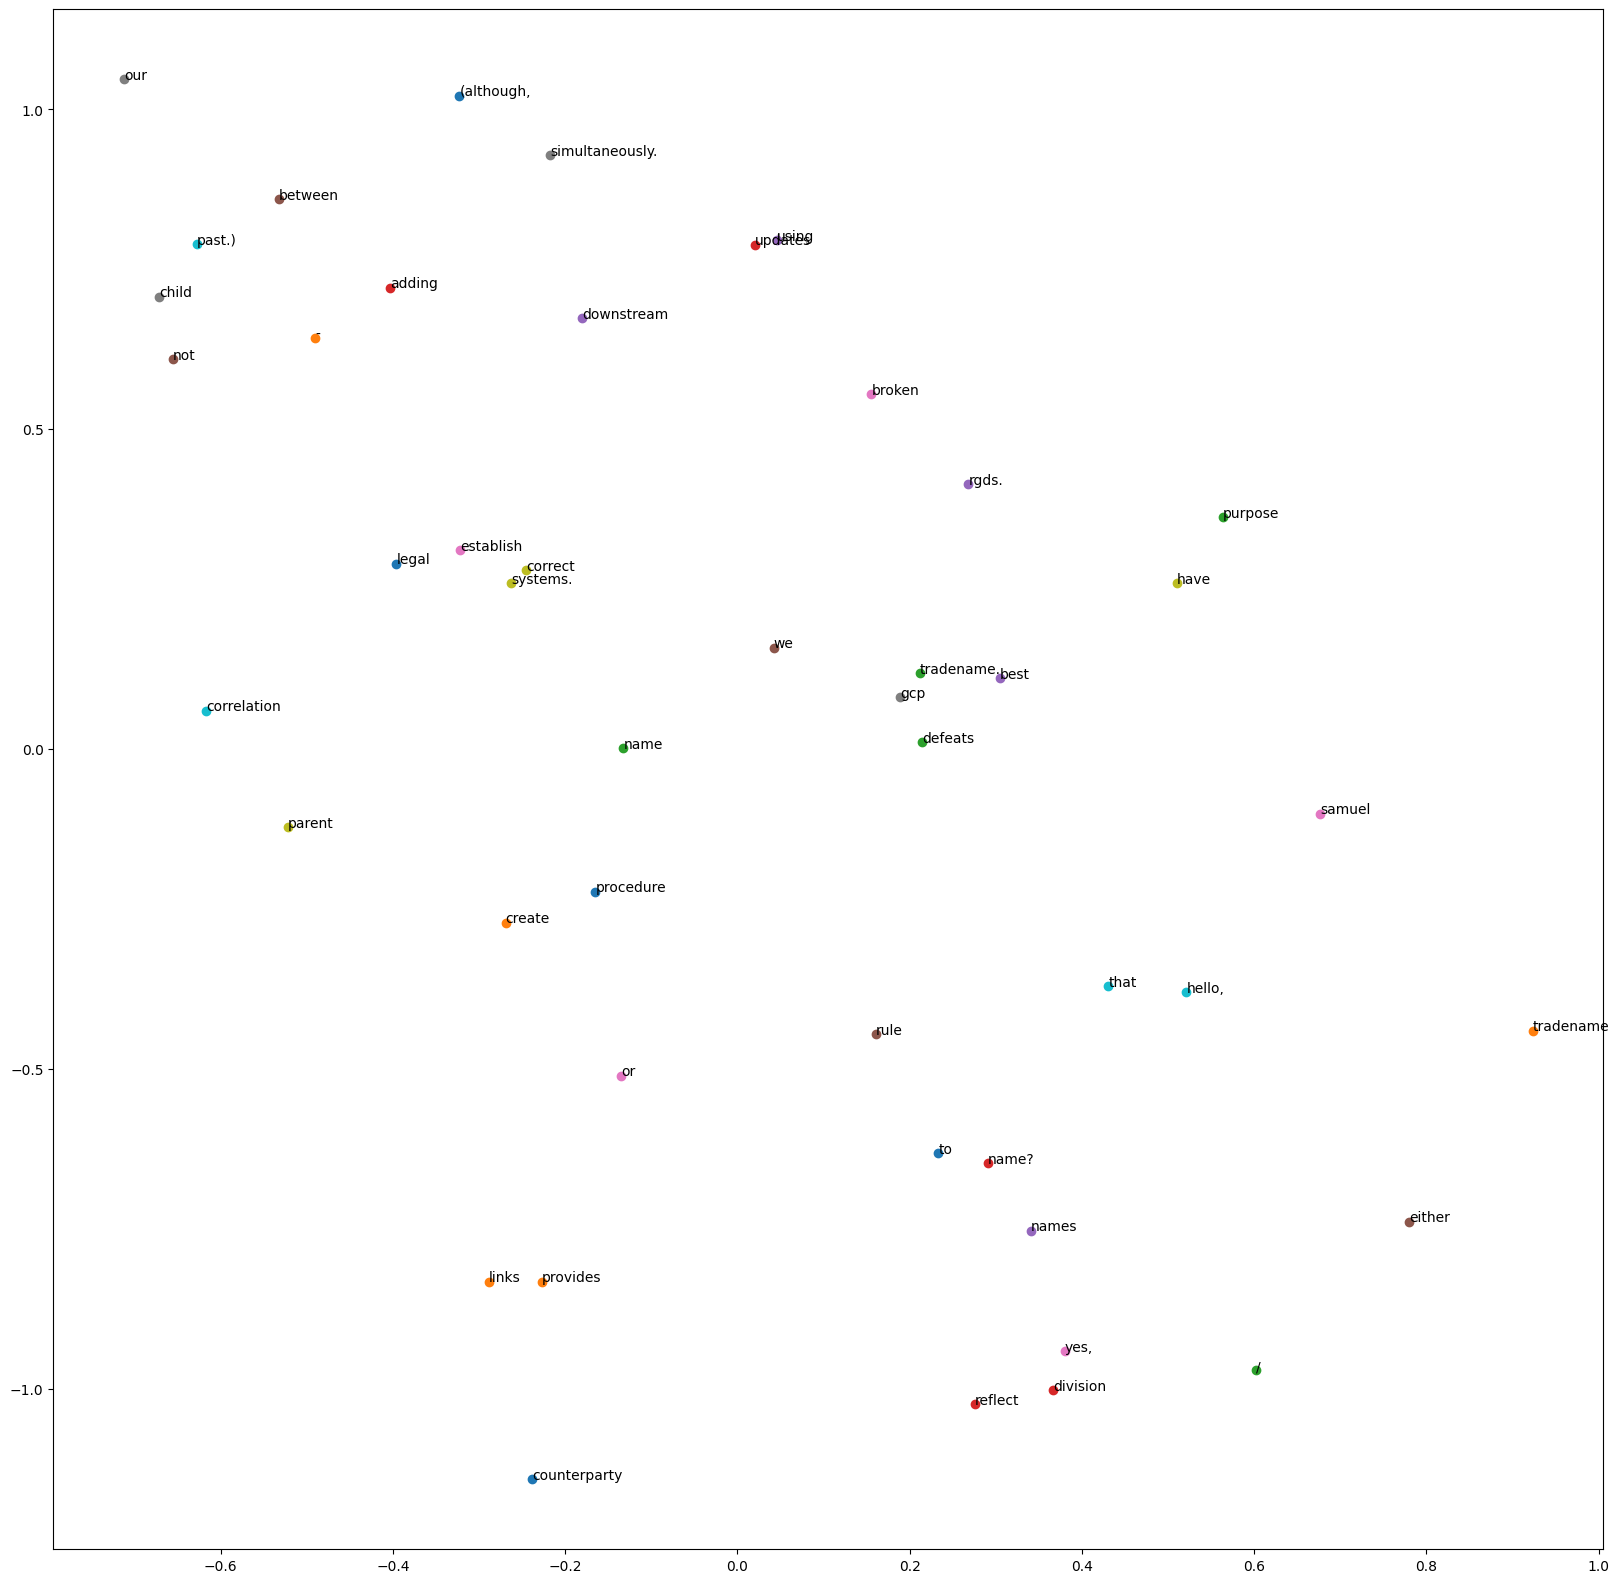

In [ ]:
plotting(unique_word_dict=unique_word_dict,embedding_dict=embeded_dict)

In [ ]:
string = input("Enter your Syntax")

Enter your Syntaxhello ibrahim i am the most wanted
